# ReadtheDocs Retrieval Augmented Generation (RAG)

In this notebook, we are going to create a chatbot about our product documentation pages.  The chatbot is going to follow RAG steps to retrieve chunks of data using Semantic Vector Search, then the Question + Context will be fed as a Prompt to a LLM to generate an answer.

Many RAG demos use OpenAI for the Embedding Model and ChatGPT for the Generative AI model.  **In this notebook, we will demo a fully open source RAG stack.**

Using open-source Q&A with retrieval saves money since we make free calls to our own data almost all the time - retrieval, evaluation, and development iterations.

<div>
<img src="images/rag_image.png" width="80%"/>
</div>

Let's get started!

In [1]:
# For colab install these libraries in this order:
# !python -m pip install torch transformers sentence-transformers langchain
# !python -m pip install -U weaviate
# !python -m pip install unstructured openai tqdm numpy ipykernel 
# !python -m pip install ragas datasets
# !python -m pip install -U langchain

In [2]:
# Import common libraries.
import sys, os, time, pprint

In [3]:
# Function to remove newlines and double spaces from a string.
def clean_text(text):
    clean_text = text.replace("\n\n", " ")\
                     .replace("\n", " ")\
                     .replace("<br><br>", " ")\
                     .replace("<br /><br />", " ")
    
    # Remove extra whitespace.
    clean_text = ' '.join(clean_text.split())
    return clean_text

import numpy as np
import matplotlib.pyplot as plt

# Function to inspect chunk lengths in matplotlit.
def plot_chunk_lengths(chunked_docs, title_keyword):
    # Get chunk lengths.
    lengths = [len(doc.page_content) for doc in chunked_docs]

    # Mean, median lengths.
    mean_length = np.mean(lengths)
    median_length = np.median(lengths)

    # Assemble the title.
    title = f"Chunk Lengths from {title_keyword} Chunking"

    # Plot the lengths.
    plt.figure(figsize=(10, 6))  # Adjust figure size
    plt.plot(lengths, marker='o')  # Plot lengths with circle markers
    plt.title(title, fontsize=20, fontweight='bold')
    plt.xlabel('Document Index')  # X-axis label
    plt.ylabel('Length')  # Y-axis label
    plt.grid(True)  # Show grid

    # Add a horizontal line at mean and median length
    plt.axhline(y=mean_length, color='g', linestyle='-')
    plt.axhline(y=median_length, color='r', linestyle='-')
    plt.text(len(lengths)-1, mean_length, f'mean = {mean_length:.0f}', va='center', ha='left', backgroundcolor='w', fontsize=12)
    plt.text(0, median_length, f'median = {median_length:.0f}', va='center', ha='right', backgroundcolor='w', fontsize=12)

    plt.show()  # Display the plot

## Download Data

TODO: Change data source to Weaviate doc pages. <br>
The data used in this notebook is Milvus documentation web pages.

The code block below downloads all the web pages into a local directory called `rtdocs`.  

I've already uploaded the `rtdocs` data folder to github, so you should see it if you cloned my repo.

In [4]:
# # UNCOMMENT TO DOWNLOAD THE DOCS.

# # !pip install -U langchain
# from langchain_community.document_loaders import RecursiveUrlLoader

# DOCS_PAGE="https://milvus.io/docs/"

# loader = RecursiveUrlLoader(DOCS_PAGE)
# docs = loader.load()

# num_documents = len(docs)
# print(f"loaded {num_documents} documents")

# # # Subset docs for faster testing
# # docs = docs[5:7].copy()
# # num_documents = len(docs)
# # print(f"testing with {num_documents} documents")

# # Print the type of the docs.
# print(type(docs))
# print(type(docs[0]))

# docs[0].page_content[:500]

# # UNCOMMENT TO SAVE THE DOCS LOCALLY.
# OUTPUT_DIR = "../../RAG/rtdocs_new/"
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# # Convert each doc to HTML and save to the specified directory
# for doc in docs:
#     # Extract file name
#     filename = doc.metadata['source'].split('/')[-1].replace(".md", ".html")
    
#     # Check that filename is not empty
#     if filename:
#         with open(os.path.join(OUTPUT_DIR, filename), "w") as f:
#             f.write(doc.page_content)
#     else:
#         print("Filename is empty. Skipping this doc.")
#         pprint.pprint(doc.metadata)
#         pprint.pprint(doc.page_content[:500])

In [5]:
# !python -m pip install -U langchain
# !python -m pip install -U unstructured
# !python -m pip install -U langchain-community
# !python -m pip install -U langchain-huggingface
# !python -m pip install -U langchain_openai
# !python -m pip install -U python-magic

In [6]:
# From raw docs

# UNCOMMENT TO READ THE DOCS FROM A LOCAL DIRECTORY.

# Read docs into LangChain
from langchain.document_loaders import DirectoryLoader
import magic

# Load HTML files from a local directory
path = "rtdocs_new/"
global_pattern = '*.html'
loader = DirectoryLoader(path=path, glob=global_pattern)
docs = loader.load()

num_documents = len(docs)
print(f"loaded {num_documents} documents")

# Clean up \n literals and source metdata.
for doc in docs:
    doc.page_content = clean_text(doc.page_content)
    doc.metadata["source"] = \
        doc.metadata["source"]\
            .replace("rtdocs_new", "https://milvus.io/docs")\
            .replace(".html", ".md")
    
print(docs[0].page_content[:500])
pprint.pprint(docs[0].metadata)

loaded 22 documents
Docs Blog Community Stars0 Home v2.4.x About Milvus Get Started Prerequisites Install Milvus Install SDKs Quickstart Concepts User Guide Models Administration Guide Tools Integrations Example Applications FAQs API reference Quickstart This guide explains how to connect to your Milvus cluster and performs CRUD operations in minutes Before you start You have installed Milvus standalone or Milvus cluster. You have installed preferred SDKs. You can choose among various languages, including Python, J
{'source': 'https://milvus.io/docs/quickstart.md'}


In [7]:
# # List all the unique sources for these docs.
# doc_sources = set([doc.metadata['source'] for doc in docs])
# print(len(doc_sources))
# doc_sources

## Load the Embedding Model checkpoint and use it to create vector embeddings

#### What are Embeddings?

Check out TODO link for an introduction to embeddings.  

An excellent place to start is by selecting an embedding model from the [HuggingFace MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard), sorted descending by the "Retrieval Average'' column since this task is most relevant to RAG. Then, choose the smallest, highest-ranking embedding model. But, Beware!! some models listed are overfit to the training data, so they won't perform on your data as promised.  

Weaviate only supports tested embedding models that are **not overfit**!

### Use open source Embedding Model from HuggingFace

In [8]:
# !python -m pip install --upgrade langchain_huggingface

In [9]:
import torch
from langchain_huggingface import HuggingFaceEmbeddings

# Initialize torch settings for device-agnostic code
N_GPU = torch.cuda.device_count()
DEVICE = torch.device('cuda:N_GPU' if torch.cuda.is_available() else 'cpu')

# Use an embedding model.
model_name = "BAAI/bge-large-en-v1.5"
model_kwargs = {'device': DEVICE}
encode_kwargs = {'normalize_embeddings': True}
embed_model = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)
EMBEDDING_DIM = embed_model.dict()['client'].get_sentence_embedding_dimension()
print(f"MODEL: {model_name}, EMBEDDING_DIM: {EMBEDDING_DIM}")

/Users/christy/Documents/py312/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


MODEL: BAAI/bge-large-en-v1.5, EMBEDDING_DIM: 1024


### Use OpenAI Embedding model

In [10]:
# !python -m pip install --upgrade langchain_openai

In [11]:
# from langchain_openai.embeddings import OpenAIEmbeddings

# # 1. Get your API key: https://platform.openai.com/api-keys
# # 2. Save your api key in env variable.
# # https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety

# # 3. OpenAI embedding model name, `text-embedding-3-large` or `text-embedding-3-small`.
# # release notes: https://openai.com/index/new-embedding-models-and-api-updates/
# model_name = "text-embedding-3-small"
# EMBEDDING_DIM = 512

# embed_model = OpenAIEmbeddings(
#     model=model_name,
#     dimensions=EMBEDDING_DIM,
# )
# print(f"MODEL: {model_name}, EMBEDDING_DIM: {EMBEDDING_DIM}")

## Simple Chunking

In [12]:
# !python -m pip install -U lxml

In [13]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
import time, pprint

chunk_size: 512, chunk_overlap: 51.0
22 docs split into 584 child documents.


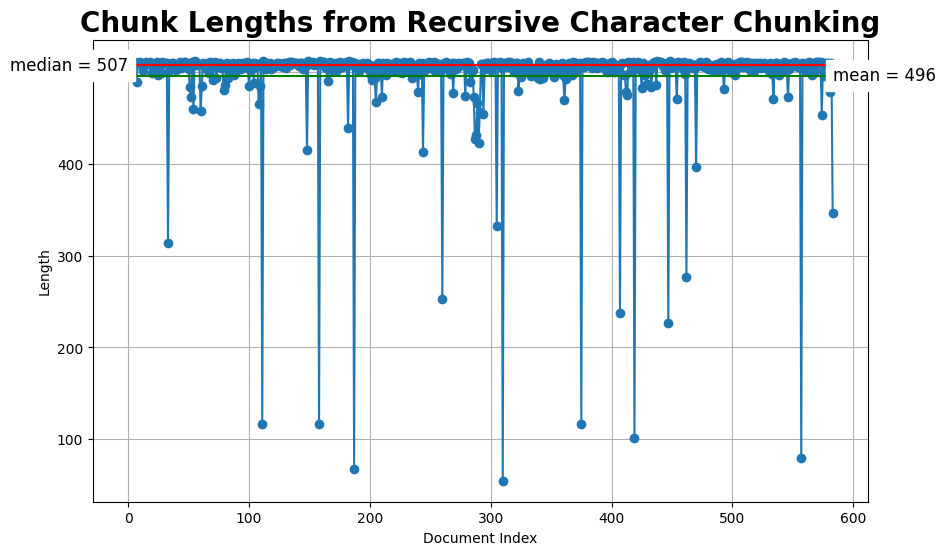

In [14]:
CHUNK_SIZE = 512
chunk_overlap = np.round(CHUNK_SIZE * 0.10, 0)
print(f"chunk_size: {CHUNK_SIZE}, chunk_overlap: {chunk_overlap}")

# The splitter to create smaller (child) chunks
# Default splitters: https://github.com/langchain-ai/langchain/blob/9ef2feb6747f5a69d186bd623b569ad722829a5e/libs/langchain/langchain/text_splitter.py#L842
child_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE, 
    chunk_overlap=chunk_overlap,
    # length_function = len,  # use built-in Python len function
    # separators = ["\n\n", "\n", " ", ". ", ""], # defaults
)

# Child docs for inspection
sub_docs = child_splitter.split_documents(docs)
print(f"{len(docs)} docs split into {len(sub_docs)} child documents.")

# Inspect chunk lengths
plot_chunk_lengths(sub_docs, 'Recursive Character')

In [15]:
# Check type of sub_docs
# List of dict metadata, string page_content
print(len(sub_docs), type(sub_docs[0]))
print(type(sub_docs[0].metadata), type(sub_docs[0].page_content))
print(sub_docs[0])
print()

# Convert sub_docs to a list of dicts.
sub_docs_dicts = [{
        "source": doc.metadata["source"],
        "text": doc.page_content}
    for doc in sub_docs
    ]
print(len(sub_docs_dicts), type(sub_docs_dicts), type(sub_docs_dicts[0]))
print("converted sub_docs_dicts:")
print(sub_docs_dicts[0])

584 <class 'langchain_core.documents.base.Document'>
<class 'dict'> <class 'str'>
page_content='Docs Blog Community Stars0 Home v2.4.x About Milvus Get Started Prerequisites Install Milvus Install SDKs Quickstart Concepts User Guide Models Administration Guide Tools Integrations Example Applications FAQs API reference Quickstart This guide explains how to connect to your Milvus cluster and performs CRUD operations in minutes Before you start You have installed Milvus standalone or Milvus cluster. You have installed preferred SDKs. You can choose among various languages, including Python, Java, Go, and' metadata={'source': 'https://milvus.io/docs/quickstart.md'}

584 <class 'list'> <class 'dict'>
converted sub_docs_dicts:
{'source': 'https://milvus.io/docs/quickstart.md', 'text': 'Docs Blog Community Stars0 Home v2.4.x About Milvus Get Started Prerequisites Install Milvus Install SDKs Quickstart Concepts User Guide Models Administration Guide Tools Integrations Example Applications FAQs

## Create Vector Store Weaviate

We'll use the LangChain integrations to create the db: 
https://python.langchain.com/docs/integrations/vectorstores/weaviate/ <br>

We'll use open source HuggingFace embeddings to create the vectors:
https://weaviate.io/developers/weaviate/model-providers/huggingface/embeddings <br>

We'll use a free sandbox Weaviate cloud cluster:
https://console.weaviate.cloud <br>
Note: you'll need to update the url and api key for each cluster.<br>

Old, but good blog about weaviate:
https://weaviate.io/blog/generative-feedback-loops-with-llms <br>

In [ ]:
# !pip install python-dotenv
# !python -m pip install -U langchain_weaviate
# !python -m pip install -U weaviate-client
import weaviate
print(f"weaviate_client: {weaviate.__version__}")

weaviate_client: 4.8.1


In [ ]:
from weaviate.classes.init import Auth
from huggingface_hub import login
from dotenv import load_dotenv
# Load the local jupyter .env file.
load_dotenv()

# Save your api key in env variable.
# https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety
# Read local Jupyter .env variables.
weaviate_url = os.getenv("WCD_DEMO_URL")
weaviate_api_key = os.getenv("WCD_DEMO_RO_KEY")
huggingface_key = os.getenv("HUGGINGFACEHUB_API_TOKEN")
login(token=huggingface_key)
# Get env variable from your shell profile.
openai_key = os.environ.get("OPENAI_API_KEY")

# Set the encoder model in header for the connection.
hf_headers = {
    "X-HuggingFace-Api-Key": huggingface_key,
}
openai_headers = {
    'X-OpenAI-Api-key': openai_key,
}

# See docs how to connect.
# https://weaviate.io/developers/weaviate/client-libraries/python#connection-helper-functions
try:
    client.close()  # Ensure the connection is closed
except:
    pass

# Connect to Weaviate Cloud
# Specify vectorizer encoder model, if any, in the headers.
client = weaviate.connect_to_weaviate_cloud(
    cluster_url=weaviate_url,
    auth_credentials=Auth.api_key(weaviate_api_key),
    headers=hf_headers,
    # headers=openai_headers,
)
print(f"Weaviate Cloud connection established: {client.is_ready()}")


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/christy/.cache/huggingface/token
Login successful
Weaviate Cloud connection established: True


In [ ]:
# client.get_meta() # see which modules are enabled in Weaviate Embedded

In [22]:
from langchain_weaviate.vectorstores import WeaviateVectorStore

try:
    # DELETE THE COLLECTION AND ALL ITS DATA
    client.collections.delete("web_docs")
    print("Collection deleted.")
except:
    pass

# Insert sub-docs into weaviate
start_time = time.time()

db = WeaviateVectorStore.from_documents(
    sub_docs, embed_model, 
    client=client, 
    index_name="web_docs")

end_time = time.time()
print(f"Inserted {len(sub_docs)} documents in {end_time - start_time:.2f} seconds.")
# Embedded AND inserted 584 documents in 3m 24.3s

Collection deleted.
Inserted 584 documents in 357.21 seconds.


In [23]:
# Get the collection.
collection = client.collections.get("web_docs")

# Count how many documents are in the collection.
response = collection.aggregate.over_all(total_count=True)
print(response)
assert response.total_count == len(sub_docs)

# Inspect one object.
object = collection.query.fetch_objects(limit=1).objects[0]
print(f"Schema: {object.properties.keys()}")
print(object.properties.get("text"))
print(object.properties.get("source"))

AggregateReturn(properties={}, total_count=584)
Schema: dict_keys(['text', 'source'])
[dockernode02] PLAY [Create milvus coords] *************************************************************************************** TASK [Gathering Facts] ******************************************************************************************** ok: [dockernode01] TASK [rootcoord] ************************************************************************************************** changed: [dockernode01] TASK [datacoord]
https://milvus.io/docs/aws.md


## Define 4 questions

In [24]:
# Define a sample question about your data.
QUESTION1 = "What do the parameters for HNSW mean?"
QUESTION2 = "What are good default values for HNSW parameters with 25K vectors dim 1024?"
QUESTION3 = "What does nlist vs nprobe mean in ivf_flat?"
QUESTION4 = "What is the default AUTOINDEX index and vector field distance metric in Milvus?"

# In case you want to ask all the questions at once.
QUERY = [QUESTION1, QUESTION2, QUESTION3, QUESTION4]

# Inspect the length of one question.
QUERY_LENGTH = len(QUESTION2)
print(f"example query length: {QUERY_LENGTH}")

example query length: 75


## DB Retrieval

First some definitions:
- "Retrieval" = query, similar concept to SQL fetch.
- "Search" = find nearest neighbors in vector space.

Note:  We'll use LangChain, which uses Weaviate's Hybrid Search: https://weaviate.io/developers/weaviate/api/graphql/search-operators#hybrid <br>
https://python.langchain.com/docs/integrations/vectorstores/weaviate/

💡 By their nature, vector searches are "semantic" searches.  For example, if you were to search for "leaky faucet": 
> **Key-word Search** - either or both words "leaky", "faucet" would have to match some text in order to return a web page or link text to the document.

> **Semantic search** - results containing words "drippy" "taps" could be returned because these words mean the same things.

> **Hybrid search** - using hyperparam <i>**alpha**</i>, take a linear combination of the keyword and semantic search results.

In [36]:
from weaviate.classes.query import Filter

# SELECT A PARTICULAR QUESTION TO ASK.
SAMPLE_QUESTION = QUESTION4
SAMPLE_QUESTION

# Client re-connect if necessary.
if not client.is_connected():
    client.connect()

# Langchain embed question automatically not working, do it manually.
# Manually embed the question.
query_vector = embed_model.embed_query(SAMPLE_QUESTION)
query_vector[:5]

# Set top_k.
TOP_K = 2

# Add a filter
# Loop through possible filter strings.
for filter_str in ["https://milvus.io/docs/index.md"]:
    search_filter = Filter.by_property("source").equal(filter_str)

    # Semantic search with filter
    docs = db.similarity_search_with_score(
        SAMPLE_QUESTION, 
        filters=search_filter, 
        k=TOP_K, 
        alpha=0.3)

    print(len(docs))
    assert len(docs) <= TOP_K

# Inspect the filtered search results.
contexts = []
sources = []
print(f"Question: {SAMPLE_QUESTION}")
for i, doc in enumerate(docs):
    print(f"\nDocument {i+1}, score {doc[1]:.2f}:")
    print(doc[0].page_content[:100] + "...")
    print(doc[0].metadata["source"])
    contexts.append(doc[0].page_content)
    sources.append(doc[0].metadata["source"])

2
Question: What is the default AUTOINDEX index and vector field distance metric in Milvus?

Document 1, score 0.91:
2)) // Output // // [ // { // "params": [ // { // "key": "index_type", // "value": "AUTOINDEX" // },...
https://milvus.io/docs/index-vector-fields.md

Document 2, score 0.78:
Set up index for the collection // 4.1. Set up the index parameters res = await client.createIndex({...
https://milvus.io/docs/index-vector-fields.md


In [37]:
# Combine all the contexts together by space.
contexts_combined = ' '.join(contexts)
# Lance Martin, LangChain, says put best contexts at end.
contexts_combined = ' '.join(reversed(contexts))
# Remove double slashes.
contexts_combined = contexts_combined.replace("//", "")

# Combine all the unique sources together by comma.
source_combined = ' '.join(reversed(list(dict.fromkeys(sources))))
print(f"sources: {source_combined}")

print(f"Length contexts: {len(contexts_combined)}")

sources: https://milvus.io/docs/index-vector-fields.md
Length contexts: 953


In [48]:
# # Print out retrievals for copy/paste into Golden Eval Dataset.
# pprint.pprint(contexts_combined)
# contexts_combined

In [39]:
# Delete the Weaviate collection and doc store.
# del vectorstore, retriever, store

# Use an LLM to Generate an answer (G-part of RAG) to the user's question using the retrieved context.

Many different generative LLMs exist these days.  Check out the lmsys [leaderboard](https://chat.lmsys.org/?leaderboard).

In this notebook, we'll try these LLMs:
- The newly released open-source Llama 3.2 from Meta.
- The cheapest, paid model from Anthropic Claude3 Haiku.
- gpt-4o-mini from Openai.

In [40]:
# TODO, try out Weaviate's built-in generator models.
# https://github.com/weaviate-tutorials/intro-workshop/blob/main/IntroWorkshop2/vectorSearch.ipynb

In [41]:
## Setup LLM for Answer Generation (G-part of RAG)

# Define temperature for the LLM and random seed.
TEMPERATURE = 0.1
TOP_P = 0.9
RANDOM_SEED = 415
MAX_TOKENS = 512
FREQUENCY_PENALTY = 2

### Try Meta Llama 3 with Ollama to generate a human-like chat response to the user's question

Follow the instructions to install ollama and pull a model.<br>
https://github.com/ollama/ollama

View details about which models are supported by ollama. <br>
https://ollama.com/library/llama3

That page says `ollama run llama3` will by default pull the latest "instruct" model, which is fine-tuned for chat/dialogue use cases.

The other kind of llama3 models are "pre-trained" base model. <br>
Example: ollama run llama3:text ollama run llama3:70b-text

**Format** `gguf` means the model runs on CPU.  gg = "Georgi Gerganov", creator of the C library model format ggml, which was recently changed to gguf.

**Quantization** (think of it like vector compaction) can lead to higher throughput at the expense of lower accuracy.  For the curious, quantization meanings can be found on: <br>
https://huggingface.co/TheBloke/Llama-2-13B-chat-GGML/tree/main.  

Below just listing the main quantization types.
- **q4_0**: Original quant method, 4-bit.
- **q4_k_m**: Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K
- **q5_0**: Higher accuracy, higher resource usage and slower inference.
- **q5_k_m**: Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K
- **q 6_k**: Uses Q8_K for all tensors
- **q8_0**: Almost indistinguishable from float16. High resource use and slow. Not recommended for most users.

In [42]:
# !python -m pip install ollama
# !ollama pull llama3
import ollama
pprint.pprint(ollama.list()['models'])

# Verify details which model you are running.
OLLAMA_INDEX = 1
ollama_llama3p2 = ollama.list()['models'][OLLAMA_INDEX]['name']

# Print the model details.
keys = ['format', 'parameter_size', 'quantization_level']
print(f"MODEL:{ollama_llama3p2}", end=", ")
for key in keys:
    print(f"{str.upper(key)}:{ollama.list()['models'][OLLAMA_INDEX]['details'].get(key, 'Key not found in dictionary')}", end=", ")
print(end="\n\n")

[{'details': {'families': ['llama'],
              'family': 'llama',
              'format': 'gguf',
              'parameter_size': '1.2B',
              'parent_model': '',
              'quantization_level': 'Q8_0'},
  'digest': 'baf6a787fdffd633537aa2eb51cfd54cb93ff08e28040095462bb63daf552878',
  'model': 'llama3.2:1b',
  'modified_at': '2024-10-03T18:58:44.396638597-07:00',
  'name': 'llama3.2:1b',
  'size': 1321098329},
 {'details': {'families': ['llama'],
              'family': 'llama',
              'format': 'gguf',
              'parameter_size': '3.2B',
              'parent_model': '',
              'quantization_level': 'Q4_K_M'},
  'digest': 'a80c4f17acd55265feec403c7aef86be0c25983ab279d83f3bcd3abbcb5b8b72',
  'model': 'llama3.2:latest',
  'modified_at': '2024-10-03T18:55:17.771588977-07:00',
  'name': 'llama3.2:latest',
  'size': 2019393189}]
MODEL:llama3.2:latest, FORMAT:gguf, PARAMETER_SIZE:3.2B, QUANTIZATION_LEVEL:Q4_K_M, 



In [43]:
# Set the Meta Llama prompt.

SYSTEM_PROMPT = f"""First, check if the provided Context is relevant to 
the user's question.  Second, only if the provided Context is strongly relevant, 
answer the question using the Context.  Otherwise, if the Context is not 
strongly relevant, answer the question without using the Context.  
Be clear, concise, relevant.  Answer clearly, in fewer than 2 sentences.
Grounding sources: {source_combined}
Context: {contexts_combined}
"""
print(f"Length prompt: {len(SYSTEM_PROMPT)}")

# Inspect the prompt.
# pprint.pprint(SYSTEM_PROMPT)

Length prompt: 1378


In [44]:
# Send the question to llama 3 chat.
start_time = time.time()
response = ollama.chat(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model=ollama_llama3p2,
    stream=False,
    options={"temperature": TEMPERATURE, "seed": RANDOM_SEED,
             "top_p": TOP_P, 
            #  "max_tokens": MAX_TOKENS,
             "frequency_penalty": FREQUENCY_PENALTY}
)
ollama_llama3_time = time.time() - start_time

# Print the question and answer along with grounding sources and citations.
print(f"Question: {SAMPLE_QUESTION}")
print(response['message']['content'])
print(f"ollama_llama3_time: {format(ollama_llama3_time, '.2f')} seconds")

Question: What is the default AUTOINDEX index and vector field distance metric in Milvus?
The default AutoIndex configuration for an "AUTOINDEX" type with a cosine similarity metric uses 128 dimensions. However, this information isn't explicitly stated in the provided context.

According to https://milvus.io/docs/index-vector-fields.md , 

- The `index_type` is set as `"AUTOINDEX"` by default.
- For AutoIndex configuration of an index field, it will use a cosine similarity metric with 128 dimensions.
ollama_llama3_time: 12.56 seconds


## Also try OpenAI

💡 Note: For use cases that need to always be factually grounded, use very low temperature values while more creative tasks can benefit from higher temperatures.

In [45]:
# Create the OpenAI prompt.
# Note: for json output ask system prompt "output in JSON".

SYSTEM_PROMPT = f"""First, check if the provided Context is relevant to 
the user's question.  Second, only if the provided Context is strongly relevant, 
answer the question using the Context.  Otherwise, if the Context is not 
strongly relevant, answer the question without using the Context.
Be clear, concise, relevant.  Answer clearly, easy to understand, 
fewer than 2 sentences, and cite unique grounding sources.
Grounding sources: {source_combined}
Context: {contexts_combined}
"""
print(f"Length prompt: {len(SYSTEM_PROMPT)}")


# Inspect the prompt.
# pprint.pprint(SYSTEM_PROMPT)

Length prompt: 1429


In [46]:
import openai, pprint
from openai import OpenAI

# 1. Define the generation llm model to use.
# https://openai.com/blog/new-embedding-models-and-api-updates
# LLM_NAME = "gpt-3.5-turbo"
LLM_NAME = "gpt-4o-mini"

# 2. Get your API key: https://platform.openai.com/api-keys
# 3. Save your api key in env variable.
# https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety
openai_client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

# 4. Generate response using the OpenAI API.
start_time = time.time()
response = openai_client.chat.completions.create(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model=LLM_NAME,
    temperature=TEMPERATURE,
    seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY,
    # response_format={ "type": "json_object" } # for json
)
chatgpt_4o_mini_time = time.time() - start_time

# Print the question and answer along with grounding sources and citations.
print(f"Question: {SAMPLE_QUESTION}")

# 5. Print all answers in the response.
for i, choice in enumerate(response.choices, 1):
    pprint.pprint(f"Answer: {choice.message.content}")
    print("\n")
print(f"chatgpt_4o_mini_time: {format(chatgpt_4o_mini_time, '.5f')}")

Question: What is the default AUTOINDEX index and vector field distance metric in Milvus?
('Answer: The default AUTOINDEX index in Milvus uses the COSINE distance '
 'metric for vector fields.')


chatgpt_4o_mini_time: 0.61027


In [47]:
# Props to Sebastian Raschka for this handy watermark.
# !python -m pip install watermark
%load_ext watermark

%watermark -a 'Christy Bergman' -v -p unstructured,lxml,torch,weaviate,langchain,ollama,openai --conda

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Christy Bergman

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.26.0

unstructured: 0.15.13
lxml        : 5.3.0
torch       : 2.4.0
weaviate    : 4.8.1
langchain   : 0.3.3
ollama      : 0.3.3
openai      : 1.51.0

conda environment: n/a

